In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import pickle
import keras.models as models

from keras.layers import BatchNormalization
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.core import Dense, Reshape, Flatten, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 

Using TensorFlow backend.


In [79]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("RML2016.10b.dat",'rb'), encoding = "latin1")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
dataset = []  
data_labels = []
for mod in mods:
    for snr in snrs:
        dataset.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  data_labels.append((mod,snr))
dataset = np.vstack(dataset)

In [80]:
print("dataset size = %d" % len(dataset))
print("number of features for each instance = %d" % len(dataset[0]))
print("number of elements in each feature = %d" % len(dataset[0][0]))

dataset size = 1200000
number of features for each instance = 2
number of elements in each feature = 128


## Split the data into 50% for training/validation and 50% for testing.

In [81]:
training_data, test_data, training_labels_snrs, test_labels_snr = train_test_split(dataset, data_labels, test_size = 0.5)

training_labels = [label[0] for label in training_labels_snrs]
test_labels = [label[0] for label in test_labels_snr]

print("training data size: %d" % len(training_data))
print("test data size: %d" % len(test_data))
print("training data labels size: %d" % len(training_labels))
print("test data labels size: %d" % len(test_labels))

training data size: 600000
test data size: 600000
training data labels size: 600000
test data labels size: 600000


In [8]:
del(dataset)
gc.collect()

828

In [86]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)


training_integer_encoded = label_encoder.fit_transform(np.array(training_labels))
training_integer_encoded = training_integer_encoded.reshape(len(training_integer_encoded), 1)
training_labels = onehot_encoder.fit_transform(training_integer_encoded)

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)


test_integer_encoded = label_encoder.fit_transform(np.array(test_labels))
test_integer_encoded = training_integer_encoded.reshape(len(test_integer_encoded), 1)
test_labels = onehot_encoder.fit_transform(test_integer_encoded)


/home/mostafayousry/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/mostafayousry/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "cate

## Build the Convolutional Neural Network

In [25]:
cnn_model = models.Sequential([
    
    Reshape([1, 2, 128], input_shape = (2, 128)),
    
    Convolution2D(activation="relu", padding = 'same', data_format="channels_first", filters=64, kernel_size=(1, 3)),
    
    Convolution2D(activation="relu", padding = 'same', data_format="channels_first", filters=16, kernel_size=(2, 3)),
    
    Flatten(),
    
    Dense(units=128, activation="relu"), 
    
    Dense(units=10, activation="softmax")
    
])

cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 2, 128)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 2, 128)        6160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 532,122
Trainable params: 532,122
Non-trainable params: 0
_________________________________________________________________


In [19]:
fitting_progress = cnn_model.fit(training_data, training_labels, epochs=100,
              batch_size=512, validation_split= 0.01,
              callbacks=[
                  EarlyStopping(patience=5, monitor = 'val_loss', mode = 'min'),
                  ModelCheckpoint("cnn-best-model.hdf5", monitor='val_loss', save_best_only=True, mode='min', period=1)
              ])

Train on 594000 samples, validate on 6000 samples
Epoch 1/100
594000/594000 [==============================] - 483s 813us/step - loss: 1.6697 - acc: 0.3297 - val_loss: 1.3593 - val_acc: 0.4562
Epoch 2/100
594000/594000 [==============================] - 490s 825us/step - loss: 1.2808 - acc: 0.4723 - val_loss: 1.2201 - val_acc: 0.4982
Epoch 3/100
594000/594000 [==============================] - 492s 829us/step - loss: 1.2029 - acc: 0.4984 - val_loss: 1.1686 - val_acc: 0.5148
Epoch 4/100
594000/594000 [==============================] - 496s 835us/step - loss: 1.1673 - acc: 0.5119 - val_loss: 1.1657 - val_acc: 0.5040
Epoch 5/100
594000/594000 [==============================] - 496s 834us/step - loss: 1.1407 - acc: 0.5232 - val_loss: 1.1353 - val_acc: 0.5225
Epoch 6/100
594000/594000 [==============================] - 505s 850us/step - loss: 1.1220 - acc: 0.5306 - val_loss: 1.1196 - val_acc: 0.5238
Epoch 7/100
594000/594000 [==============================] - 516s 869us/step - loss: 1.1054 

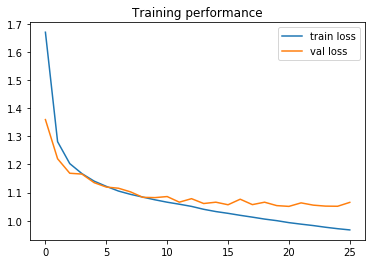

In [20]:
plt.figure()
plt.title('Training performance')
plt.plot(fitting_progress.epoch, fitting_progress.history['loss'], label='train loss')
plt.plot(fitting_progress.epoch, fitting_progress.history['val_loss'], label='val loss')
plt.legend()

In [83]:
cnn_best_model = load_model('cnn-best-model.hdf5')

In [88]:
score = cnn_best_model.evaluate(test_data, test_labels, verbose=0, batch_size=512)
print(score)

[8.317505582987467, 0.09974666666905085]


In [24]:
score = cnn_model.evaluate(test_data, test_labels, verbose=0, batch_size=512)
print(score)

[8.500556257019044, 0.10013999999841054]


In [89]:
test_predicted_labels = cnn_best_model.predict(test_data, batch_size = 512)

In [90]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

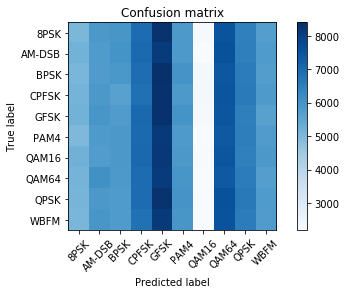

In [91]:
confusion_matrix = np.zeros([10,10])
for i in range(len(test_data)):
    true_label_indx = list(test_labels[i]).index(1)
    predicted_label_indx = np.argmax(test_predicted_labels[i])
    confusion_matrix[true_label_indx,predicted_label_indx] += 1

plot_confusion_matrix(confusion_matrix, labels = mods)

In [32]:
mods_snrs = np.array(test_labels_snr)
snrs = mods_snrs[:,1]
unique_snrs = set(mods_snrs[:,1])

Overall Accuracy: 0.100409
Overall Accuracy: 0.099040
Overall Accuracy: 0.099646
Overall Accuracy: 0.101115
Overall Accuracy: 0.103401
Overall Accuracy: 0.099559
Overall Accuracy: 0.101901
Overall Accuracy: 0.100953
Overall Accuracy: 0.101468
Overall Accuracy: 0.101974
Overall Accuracy: 0.100761
Overall Accuracy: 0.099750
Overall Accuracy: 0.101986
Overall Accuracy: 0.098312
Overall Accuracy: 0.098890
Overall Accuracy: 0.099642
Overall Accuracy: 0.099068
Overall Accuracy: 0.101906
Overall Accuracy: 0.097746
Overall Accuracy: 0.099045


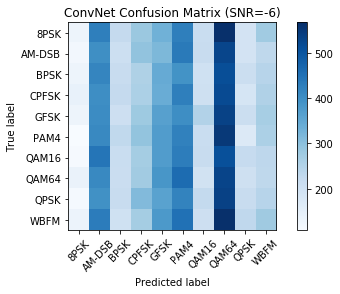

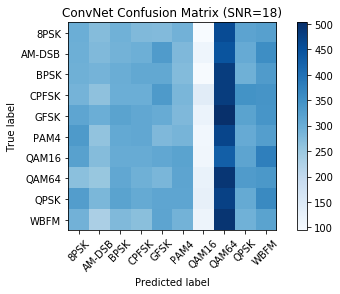

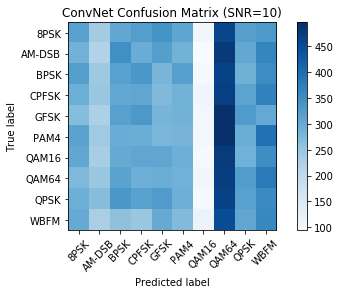

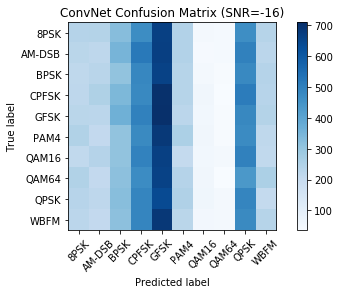

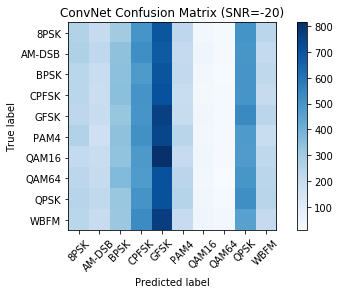

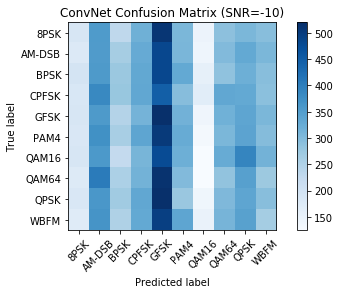

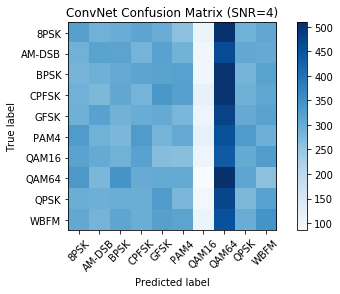

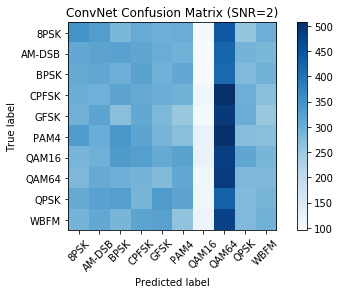

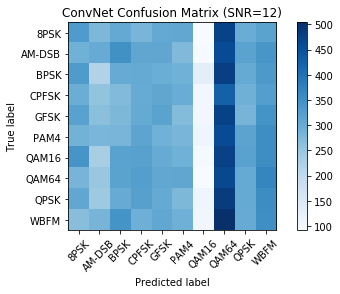

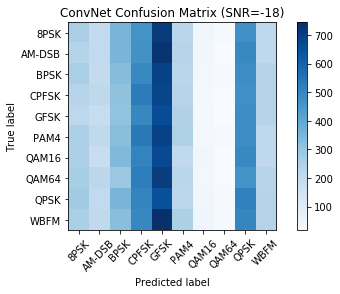

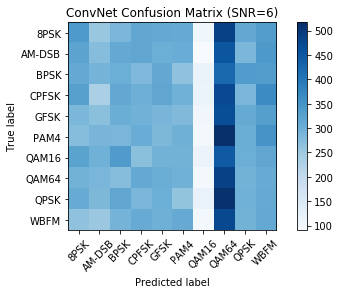

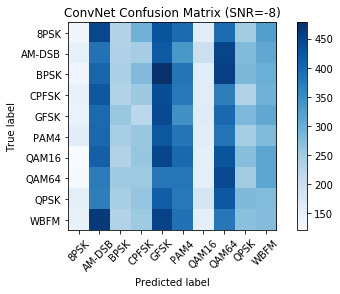

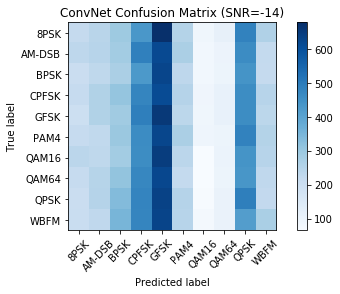

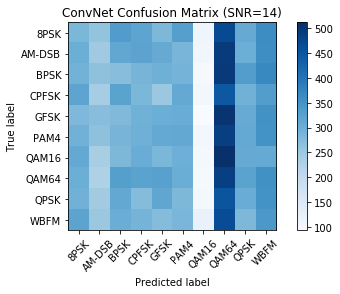

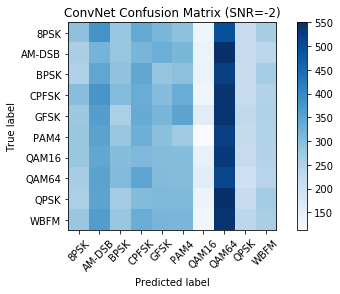

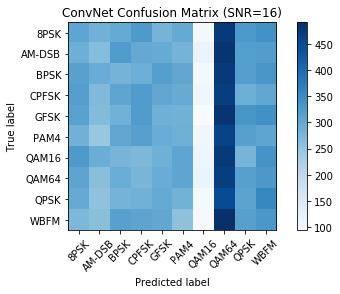

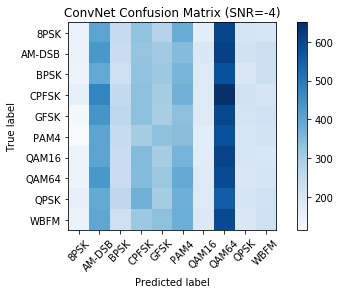

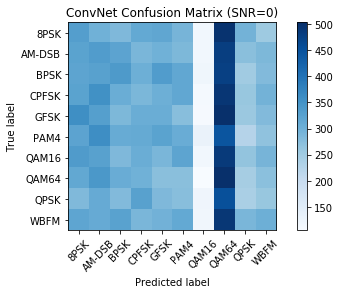

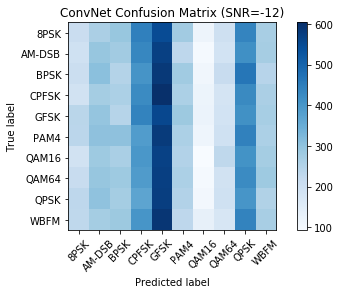

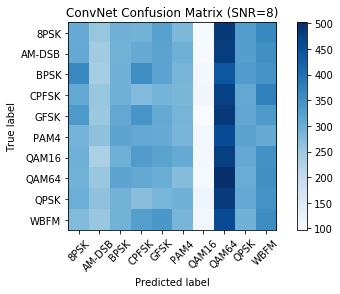

In [73]:
acc = []
for snr in unique_snrs:

    snr_points_indx = np.where(snrs == snr)[0]
  
    snr_test_data = test_data[snr_points_indx]
    
    snr_test_labels = test_labels[snr_points_indx]    
   
    snr_test_predicted_labels = cnn_best_model.predict(snr_test_data, batch_size = 512)
    
    confusion_matrix = np.zeros([10,10])
    for i in range(len(snr_test_data)):
        true_label_indx = list(snr_test_labels[i]).index(1)
        predicted_label_indx = np.argmax(snr_test_predicted_labels[i])  
        confusion_matrix[true_label_indx,predicted_label_indx] += 1

    plt.figure()
    plot_confusion_matrix(confusion_matrix, labels=mods, title="ConvNet Confusion Matrix (SNR=%s)"%(snr))
    
    correct = np.sum(np.diag(confusion_matrix))
    noncorrect = np.sum(confusion_matrix) - cor
    print("Overall Accuracy: %f" % (correct / (correct + noncorrect)))
    acc.append(1.0*correct / (correct + noncorrect))

Text(0.5, 1.0, 'Accuracy agnist SNR')

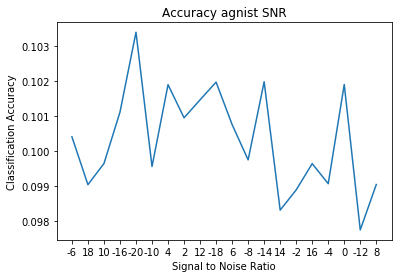

In [78]:
# Plot accuracy curve
plt.plot(list(unique_snrs), acc) 
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy agnist SNR")